## PART 1:

In this part of the mini-project, we use NinaPro Dataset 1 (https://ninapro.hevs.ch/instructions/DB1.html) to classify and predict the movement classes associated to the different EMG signals for a single subject. Participants are tasked  to replicate the movement shown on the screen. Surface EMG signals are recorded while the  participants perform the tasks.  

Article: “Electromyography Data for Non-Invasive Naturally-Controlled Robotic Hand Prostheses” (Scientific Data, 2014)


Method:Here we are concerned with Surface electromyography (sEMG). The sEMG data are acquired using 10 Otto Bock MyoBock 13E200 electrodes, while kinematic data are acquired using a Cyberglove 2 data glove. The sampling rate on sEMG is 100 Hz.

The data comes from S2: Intact (this is, non amputee)	Right Handed	Male	27	years old

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

### 1. Preprocess and Visualize

In [2]:
data = loadmat("/Users/pamelavandenenden/Desktop/nssp_project2/s2/S2_A1_E1.mat")

In [3]:
print(f"What kind of data structure are we working with? {type(data)}")
print(f"What are the keys of the data structure? {[key for key in data.keys()]}") 

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']


#### 1a. Review Data

In [4]:
#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement

#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 


emg_rectified = data["emg"].copy()
print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [5]:
# We want to know how many movements. repetitions and number of channels in this data set:


n_stimuli = len(np.unique(stimulus)) - 1  # -1 because 0 is the resting condition

n_repetitions = len(np.unique(repetition)) - 1  # -1 because 0 is not a repetition


n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}')
print(f'How many channels are there? {n_channels}')

How many types of movement are there? 12
How many repetitions are there? 10
How many channels are there? 10


In [6]:
#Duration of trials (i.e. number of samples within a repetition of a stimulus):

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

#### 1b. Preprocess

Question 1: Visualize and preprocess the data for subject 2 (use only the first exercise set:  S2_A1_E1 with 12 actions). Does the data look reasonable? Did you need to remove  any trials?  

In [8]:
# Calculate sampling frequency:

# We calculate the duration of the first trial under two EMG sampling rate assumptions from the data website: Both 100 Hz and 2000 Hz are reported.

samples_in_trial = number_of_samples_per_trial[0, 0] # e.g., ~400 samples
duration_100hz = samples_in_trial / 100.0
duration_2000hz = samples_in_trial / 2000.0

print(f"Trial Samples: {int(samples_in_trial)}")
print(f"Calculated Duration at 100 Hz:  {duration_100hz:.2f} s")
print(f"Calculated Duration at 2000 Hz: {duration_2000hz:.2f} s") 

# Logic: A standard isometric contraction trial typically lasts 3-5 seconds.
if duration_100hz > 1.0:
    fs = 100
    print(f"Detected Sampling Frequency: {fs} Hz")
else:
    fs = 2000
    print(f"Detected Sampling Frequency: {fs} Hz")

Trial Samples: 307
Calculated Duration at 100 Hz:  3.07 s
Calculated Duration at 2000 Hz: 0.15 s
Detected Sampling Frequency: 100 Hz


Conclusion : 100 Hz, the standard Ninapro DB1 protocol (Otto Bock sensors)


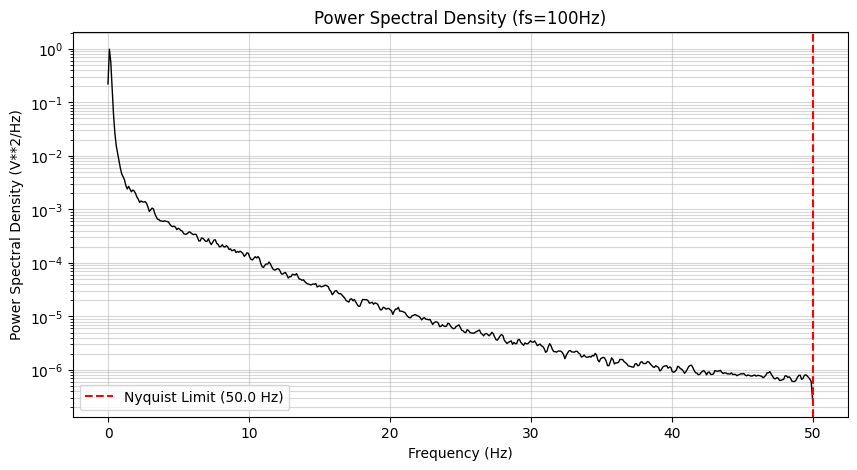

In [9]:
# Spectral Density Filter: PSD using welch method to inspect frequency content:

#Inspect channel 1:
freqs, psd = welch(emg_rectified[:, 0], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd, color='black', linewidth=1)
plt.title(f"Power Spectral Density (fs={fs}Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (V**2/Hz)")
plt.grid(True, which='both', alpha=0.5)

# Mark the Nyquist Frequency (fs/2)
nyquist = fs / 2
plt.axvline(nyquist, color='red', linestyle='--', label=f'Nyquist Limit ({nyquist} Hz)')
plt.legend()
plt.show()

Conclusion: The maximum observable frequency (Nyquist frequency) is half the sampling rate. The frequency content on the x-axis terminates exactly at 50 Hz.

Do we need bandpass filtering? No, our data is already below 500Hz. 
Do we need notch filtering? No, there is no spike at 50Hz in the PSD plot. 

##### Segment and Smooth the data

Segmentation of continous stream into sample, sliding window to calculate the envelope of the raw data. That is, smoothing.

First, we rectify. Rectification: The raw EMG signal swings positive and negative. If we averaged them, they would cancel out to zero. So, we flip all negative values to be positive. Now the signal represents pure "magnitude" or energy


Second we smooth. Smoothing: The rectified signal is still too "spiky" (stochastic). Muscles don't turn on and off 100 times a second; they ramp up and down slowly. We apply the Moving Average. 

In [10]:
# Define the smoothing filter:

# Moving average window (as per Lab instructions)
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length # Average of N (25) neighboring samples

# Initialize the empty data structures
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]


# Rectification and Smoothing Loop:
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Create the mask to find where this specific trial is in the data
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        
        # --- DEFINE current_window ---
        # Slice the raw data using the mask
        current_window = emg_rectified[idx, :] 
        
        # --- DEFINE envelope ---
        # Apply rectification (abs) and smoothing (convolve) to every channel
        envelope = np.array([np.convolve(np.abs(col), mov_mean_weights, mode='same') for col in current_window.T]).T #np.abs(col): Rectification. It turns all negative muscle values positive.

        # Store the results in the data structures
        emg_windows[stimuli_idx][repetition_idx] = current_window
        emg_envelopes[stimuli_idx][repetition_idx] = envelope



In [12]:
# Now, we want to check our raw and enveloped data visually using interactive plots:
# Important: The y axis limits should be the same across all channels for better comparison. 

from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np

def view_trial(stimulus=1, repetition=1):
    # Convert to Python Index
    s_idx = stimulus - 1
    r_idx = repetition - 1

    current_raw = emg_windows[s_idx][r_idx]
    current_env = emg_envelopes[s_idx][r_idx]

    # We set a minimum floor (e.g., 0.1) to prevent errors on empty channels
    raw_ylim = max(np.max(current_raw) * 1.1, 0.05)
    env_ylim = max(np.max(current_env) * 1.1, 0.05)

    # Row 1: Raw | Row 2: Envelope
    fig, axes = plt.subplots(2, 10, figsize=(18, 6), constrained_layout=True)
    
    # 10 EMG channels
    number_of_emg_channels = current_raw.shape[1]

    for ch in range(number_of_emg_channels): 
        # RAW
        ax_raw = axes[0, ch]
        ax_raw.plot(current_raw[:, ch], color='#4c72b0')
        ax_raw.set_title(f"Ch {ch+1}")
        ax_raw.set_ylim(0, raw_ylim) # Uniform Scale
        ax_raw.grid(True, alpha=0.3)
        if ch == 0: ax_raw.set_ylabel("RAW")
        
        # ENVELOPE
        ax_env = axes[1, ch]
        ax_env.plot(current_env[:, ch], color='#dd8452', linewidth=2)
        ax_env.set_title(f"Ch {ch+1}")
        ax_env.set_ylim(0, env_ylim) # Uniform Scale
        ax_env.grid(True, alpha=0.3)
        if ch == 0: ax_env.set_ylabel("ENVELOPE")

    plt.suptitle(f"Stimulus {stimulus} | Repetition {repetition}", fontsize=16)
    plt.show()

# Create the sliders
print("Use the sliders to loop through your data:")
interact(view_trial, 
         stimulus=IntSlider(min=1, max=n_stimuli, step=1, value=1), 
         repetition=IntSlider(min=1, max=n_repetitions, step=1, value=1));

Use the sliders to loop through your data:


interactive(children=(IntSlider(value=1, description='stimulus', max=12, min=1), IntSlider(value=1, descriptio…

To review: Channels were the values seem a bit too high. I have not deleted them since in the previous lab we were not taught how to do that. 

Stimulus 7, Repetition 1, Channel 9 

Stimulus 7, Repetition 4, Channel 9 

Stimulus 7, Repetition 7, Channel 9

Stimulus 9, Repetition 8: Channel 9

Stimulus 11, Repetition 5, Channel 1

### 2. Feature Selection

Question 3: Extract features from the trials (at least 5 different ones), explain briefly why you picked these features. Visualize the typical values of  the features across the different trials. What do you see? Are the values similar  between repetitions and between channels? Explain the possible reasons for  similarity/discrepancies.  

I looked at this paper: https://www.nature.com/articles/sdata201453

These are the features they extracted, plus Discrete Wavelet Transform. But I could not make this function work in my computer. So, Gemini recomends using PSD. 

1. Root Mean Square (RMS)

    Definition: The square root of the arithmetic mean of the squares of the values.
    Scientific Significance: RMS represents the electrical power of the signal. In electromyography, it models the amplitude of the Motor Unit Action Potentials (MUAPs). Under non-fatiguing conditions, RMS is linearly (or quasi-linearly) proportional to the isometric force generated by the muscle.

2. Hudgins’ Time Domain (TD) Features: Proposed by Hudgins et al. (1993), this set characterizes the signal pattern without requiring a transformation to the frequency domain, maintaining low computational complexity.

- Mean Absolute Value (MAV):
    Definition: The average of the absolute amplitude values in the window.
    Significance: A linear estimator of muscle contraction intensity. It is the most common metric used to detect the onset of movement vs. the resting state.

- Waveform Length (WL):
    Definition: The cumulative summation of the absolute difference between consecutive sample points.
    Significance: WL quantifies signal complexity. It implicitly captures both the amplitude and the frequency of the signal (since higher frequency signals travel a longer "distance" over the same time period).

- Zero Crossings (ZC):
    Definition: The number of times the signal amplitude crosses the zero (or mean) threshold.
    Significance: A time-domain estimate of frequency. It correlates with muscle fatigue (spectral compression causes ZC to decrease) and the recruitment of different motor unit types.

- Slope Sign Changes (SSC):
    Definition: The number of times the slope of the signal changes from positive to negative (or vice versa).
    Significance: Captures the frequency of signal turns (local maxima/minima). It provides spectral information similar to ZC but is more robust against low-voltage noise fluctuations.

3. Histogram (HIST)
    Definition: A discretization of the signal amplitude into specific bins based on a 3sigma (standard deviation) threshold.
    Scientific Significance: This estimates the Probability Density Function (PDF) of the signal. While TD features (like MAV) capture the magnitude, HIST captures the statistical distribution. This helps the classifier distinguish between movements that require similar force (similar MAV) but have different firing patterns.

4. Power Spectral Density (PSD)
    Definition: Derived via the Fourier Transform (using periodogram), this decomposes the signal into its constituent frequencies.
    Scientific Significance: This provides Frequency Domain information.

    Total Power: The integral of the PSD.
    Peak Frequency: The frequency component containing the maximum energy. This helps distinguish between different muscle groups, as frequency content varies based on fiber composition (fast-twitch vs. slow-twitch) and electrode placement.

The paper does some pre-processing that is different from what we did before:

They use butterworth filerting. 

In [14]:
from scipy.signal import butter, lfilter

fs = 100
window_size = 20   # 200 ms
step_size = 10     # 100 ms (50% overlap)
test_reps = [2, 5, 7] 

def apply_ninapro_filter(data):
    b, a = butter(N=1, Wn=1, btype='low', fs=fs)
    return lfilter(b, a, data, axis=0)

emg_processed = apply_ninapro_filter(emg_rectified)


In [18]:
from scipy.signal import periodogram

def get_features(window):
    features = []
    n_channels = window.shape[1]
    
    # 1. RMS (Root Mean Square) - Power
    rms = np.sqrt(np.mean(window**2, axis=0))
    features.extend(rms)
    
    # 2. TD (Hudgins) - Amplitude/Complexity/Freq
    mav = np.mean(np.abs(window), axis=0)
    features.extend(mav)
    wl = np.sum(np.abs(np.diff(window, axis=0)), axis=0)
    features.extend(wl)
    
    centered = window - np.mean(window, axis=0)
    zc = np.sum(np.abs(np.diff(np.sign(centered), axis=0)) > 0, axis=0)
    features.extend(zc)
    
    diff = np.diff(window, axis=0)
    ssc = np.sum(np.abs(np.diff(np.sign(diff), axis=0)) > 0, axis=0)
    features.extend(ssc)
    
    # 3. HIST (Histogram) - Distribution
    for ch in range(n_channels):
        sigma = np.std(window[:, ch])
        threshold = 3 * sigma
        if threshold == 0: threshold = 1e-6
        hist, _ = np.histogram(window[:, ch], bins=5, range=(0, threshold))
        features.extend(hist)
        
    # 4. SPECTRAL (PSD) - Frequency info (Wavelet substitute)
    for ch in range(n_channels):
        f, Pxx = periodogram(window[:, ch], fs=fs)
        features.extend([np.sum(Pxx), f[np.argmax(Pxx)]])

    return np.array(features)


### 3. Split Data:

Question 2: Split the data into training, validation, and testing sets for the subject. Why do we need  the different datasets?  

The paper also splits the data in a particular manner:

In [19]:

# Ninapro DB1 Standard Protocol:
# Test Set = Repetitions 2, 5, 7
# Training Set = All others (1, 3, 4, 6, 8, 9, 10)

test_reps = [2, 5, 7] 

# Configuration for windowing
window_size = 20  # 200 ms
step_size = 10    # 100 ms (Overlap)

In [21]:
X_train, y_train = [], []
X_test, y_test = [], []


for s_idx in range(n_stimuli):
    for r_idx in range(n_repetitions):
        
        # Current Repetition Number (1 to 10)
        current_rep = r_idx + 1
        current_label = s_idx + 1
        
        # A. Get the filtered data for this specific trial
        mask = np.logical_and(stimulus == current_label, repetition == current_rep).flatten()
        trial_data = emg_processed[mask, :]
        
        # Skip short trials
        if trial_data.shape[0] < window_size: continue
            
        # B. Sliding Window Loop
        num_windows = (trial_data.shape[0] - window_size) // step_size
        
        for i in range(num_windows):
            # Slice the window
            start = i * step_size
            end = start + window_size
            window = trial_data[start:end, :]
            
            # Extract features (using the function we defined previously)
            feats = get_features(window)
            
            # C. THE SPLIT LOGIC
            # If the repetition is in our "Test List", it goes to X_test
            # Otherwise, it goes to X_train
            if current_rep in test_reps:
                X_test.append(feats)
                y_test.append(current_label)
            else:
                X_train.append(feats)
                y_train.append(current_label)

# Convert to simple Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data:  {X_test.shape}")

Training Data: (2713, 120)
Testing Data:  (1169, 120)


In [27]:
import pandas as pd
import numpy as np

# Based on your get_features function and assuming 10 channels
n_channels = 10 
feature_names = []

# 1. RMS
feature_names.extend([f"RMS_Ch{c+1}" for c in range(n_channels)])

# 2. TD (MAV, WL, ZC, SSC)
feature_names.extend([f"MAV_Ch{c+1}" for c in range(n_channels)])
feature_names.extend([f"WL_Ch{c+1}"  for c in range(n_channels)])
feature_names.extend([f"ZC_Ch{c+1}"  for c in range(n_channels)])
feature_names.extend([f"SSC_Ch{c+1}" for c in range(n_channels)])

# 3. HIST (5 bins per channel)
for c in range(n_channels):
    feature_names.extend([f"HIST_Ch{c+1}_Bin{b+1}" for b in range(5)])

# 4. SPECTRAL (Power + Freq per channel)
for c in range(n_channels):
    feature_names.extend([f"PSD_Power_Ch{c+1}", f"PSD_Freq_Ch{c+1}"])

# Create a DataFrame for easier plotting
# We combine X_train and y_train
df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['Stimulus'] = y_train

print(f"Feature Names Created: {len(feature_names)}")
print(f"DataFrame Shape: {df_train.shape}")

Feature Names Created: 120
DataFrame Shape: (2713, 121)


#### Visualization of the features:

TBD!

### 4. Classification

Question 4:  Perform classification on the data of subject 2. Predict the action of the subject based  on the EMG signals. Use hyperparameter optimization to increase your models’  performance. You will use one of the algorithm families throughout the whole project  (meaning for part 1, 2 and 3) depending on your project variant.  

Project variant 1: Support Vector Machine

### 5. Evaluation

Question 5: Evaluate the performance using a metric of your choice. Justify why the metric is  suitable for this task and whether the performance is satisfactory. 

### 6. Selection / Dimensionality Reduction

Question 6: Perform feature selection / dimension reduction using 2 methods of your choice that you think might perform better or yield insights.  Evaluate the performance using the same metric as point 5. Is there an improvement  in the performance and why do you think this is the case?   